In [1]:
import networkx as nx
import matplotlib as plt
import numpy as np
import pandas as pd


In [2]:
def randomWave(wavelist):
    random_seed=np.random.randint(len(wavelist))
    return wavelist[random_seed]

In [3]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges      

def pathBand(path):
    path_len=len(path)
    #print(path)
    #print(path[0][0])
    resource=Resource[path[0][0]][path[0][1]][path[0][2]]
    for i in range(1,path_len):
        resource=list(map(lambda x: x[0]+x[1], zip(resource, Resource[path[i][0]][path[i][1]][path[i][2]])))
    pathbandList=zero_runs(resource) 
    
    return pathbandList

In [4]:
def bypassType(path):
    path_len=len(path)
    if(path_len==1):
        bypass_type=0
    elif(path_len==2):
        edgeLoc0=edges_list.index((path[0][0],path[0][1]))
        edgeLoc1=edges_list.index((path[1][0],path[1][1]))
        if(path[1] in Out_bypassEdges[edgeLoc0][path[0][2]] and path[0] in In_bypassEdges[edgeLoc1][path[1][2]] ) :
            bypass_type=2
        else:
            bypass_type=0
            
    elif(path_len==3):       
        edgeLoc0=edges_list.index((path[0][0],path[0][1]))
        edgeLoc1=edges_list.index((path[1][0],path[1][1]))
        edgeLoc2=edges_list.index((path[2][0],path[2][1]))
        if(path[1] in Out_bypassEdges[edgeLoc0][path[0][2]] and path[0] in In_bypassEdges[edgeLoc1][path[1][2]] ) :
            bypass_type=1
        elif(path[2] in Out_bypassEdges[edgeLoc0][path[1][2]] and path[1] in In_bypassEdges[edgeLoc1][path[2][2]] ):
            bypass_type=1
        else:
            bypass_type=0
                       
            
    return bypass_type
                
            

In [5]:
def pathBand_Ocuupy(loc1,loc2,wave1,band,index):
    path=SD_pathLink[loc1][loc2]
    pathBand=ALL_SD_bandwidth[loc1][loc2]
    for i in range(len(path)):
        for j in range(band):
            #print(path)
            #print(wave1)
            #print(Resource[path[i][0]][path[i][1]][path[i][2]][wave1+j])
            Resource[path[i][0]][path[i][1]][path[i][2]][wave1+j]+=index+1
            
    return

        
def pathUpdate():
    SR_bandwidth=[]
    #MaxBand=[]
    Hops=[]
    for i in range(len(SD_pathLink)):
        band=[]
        #Max=[]
        hops=[]        
        for j in range(len(SD_pathLink[i])):
            #cost.append(pathCost(SD_pathLink[i][j]))
            hops.append(len(SD_pathLink[i][j]))
            b=pathBand(SD_pathLink[i][j])
            #Max.append(max(b[:,1] - b[:,0]))
            band.append(b)            
        #SR_pathLink_cost.append(cost)
        SR_bandwidth.append(band)
        #MaxBand.append(Max)
        Hops.append(hops)
    global ALL_SD_bandwidth
    ALL_SD_bandwidth=SR_bandwidth
        
    return

In [6]:
def CoreSetup():
    Nodes_list=list(G.nodes)
    #Link_bypass=[]
    for i in Nodes_list:
        neighborList=list(G.neighbors(i))
        #bypasscore_num=len(neighborList)-1# set the bypass core number within each fiber 
        for j in range(len(neighborList)):
            dis=1
            while(j+dis<len(neighborList)):
                input_loc=edges_list.index((neighborList[j],i))
                output_loc=edges_list.index((i,neighborList[j+dis]))
                successFlag=0
                for m in range(7):
                    if(len(bypassEdges[input_loc][m])==0):
                        for n in range(7):
                            if(len(bypassEdges[output_loc][n])==0):
                                bypassEdges[output_loc][n].append(((neighborList[j],i,m)))
                                bypassEdges[input_loc][m].append(((i,neighborList[j+dis],n)))
                                successFlag=1
                                break
                        if(successFlag==1):
                            break
                input_loc=edges_list.index((neighborList[j+dis],i))
                output_loc=edges_list.index((i,neighborList[j]))
                successFlag=0
                for m in range(7):
                    if(len(bypassEdges[input_loc][m])==0):
                        for n in range(7):
                            if(len(bypassEdges[output_loc][n])==0):
                                bypassEdges[output_loc][n].append(((neighborList[j+dis],i,m)))
                                bypassEdges[input_loc][m].append(((i,neighborList[j],n)))
                                successFlag=1
                                break
                        if(successFlag==1):
                            break
                                                                                                        
                dis+=1
    return;

In [7]:
def edgeToLinks(path):
    pathlist=[]
    path_len=len(path)
    corePossib=7**path_len
    for i in range(corePossib):
        List=[]
        List.append((path[0]+(i%7,)))
        edgeLoc=edges_list.index(path[0])
        
        if(len(In_bypassEdges[edgeLoc][i%7])>0):
            List=[]
            continue
        for j in range(1,path_len):
            List.append((path[j]+((int(i/(7**j)%7)),)))
            edgeLoc0=edges_list.index(path[j-1])
            edgeLoc1=edges_list.index(path[j])
            if(len(Out_bypassEdges[edgeLoc0][List[j-1][2]])>0 and List[j] not in Out_bypassEdges[edgeLoc0][List[j-1][2]] ) :

                List=[]
                break
            if(len(In_bypassEdges[edgeLoc1][List[j][2]])>0 and List[j-1] not in In_bypassEdges[edgeLoc1][List[j][2]] ) :

                List=[]
                break
        edgeLoc=edges_list.index(path[path_len-1])
        if(len(Out_bypassEdges[edgeLoc][int(i/(7**(path_len-1)))])>0):            
            List=[]
            continue 
        if(len(List)>0):
            pathlist.append(List)    
    return pathlist

In [30]:
def PathAlgorithm_1(PathList,hopsList,bandwidth,pathBandList,bypassList,wave):
    Max=np.zeros(len(pathBandList))
    Sum=np.zeros(len(pathBandList))
    for i in range(len(pathBandList)):
        #print (pathBandList[i][:,1] - pathBandList[i][:,0])
        #print(i)
        #print(PathList[0])
        Max[i]=max(pathBandList[i][:,1] - pathBandList[i][:,0])
        Sum[i]=sum(pathBandList[i][:,1] - pathBandList[i][:,0])
    
    infor={"place":range(len(PathList)),
           "bypass":bypassList,
           "bandwidth": Max,
           "hops": hopsList,
           "sum":Sum
         }
    
    Path_infor=pd.DataFrame(infor)     
    #print(Path_infor)
    df=Path_infor.sort_values(by=['bandwidth',"hops","bypass"],ascending=[True,True,False]) 
    df.reset_index(drop=True, inplace=True)#reset the index sequence
    #print(df)
    Path=[]
    successful_flag=0
    for i in range(len(df)):
        if(df["bandwidth"][i]>bandwidth):
            for j in pathBandList[df["place"][i]]:
                if(wave>=j[0] and wave+bandwidth<=j[1]):
                    Path=PathList[df["place"][i]]
                    traffic_feedback.append(df["bypass"][i])
                    successful_flag=1
                    break 
        if(successful_flag==1):
            break
    if(len(Path)==0):
        traffic_feedback.append(-1)
        #print(df)
    return Path

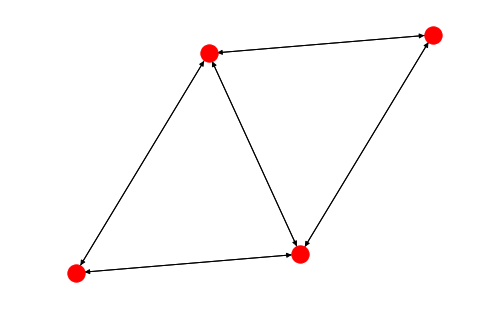

In [31]:
TrafficCost=0
node_list=[0,1,2,3]
SR_pair=[(0,1),(1,0),(1,2),(2,1),(0,2),(2,0),(2,3),(3,2),(0,3),(3,0),(1,3),(3,1)]
edges_list=[(0,1),(1,0),(1,2),(2,1),(0,2),(2,0),(2,3),(3,2),(1,3),(3,1)]
bypassEdges=[]
In_bypassEdges=[]
Out_bypassEdges=[]
for i in range(len(edges_list)):
    BY=[]
    BY0=[]
    BY1=[]
    
    for j in range(7):
        BY.append([])
        BY0.append([])
        BY1.append([])
    bypassEdges.append(BY)
    In_bypassEdges.append(BY0)
    Out_bypassEdges.append(BY1)
    

   
#先对D=2的节点进行bypass设置，在对D=3的节点进行bypass设置
#每次设置都在该link中不存在

G=nx.DiGraph()
G.add_nodes_from(node_list)
G.add_edges_from(edges_list)
nx.draw(G)

#plt.show()


link_list=[] 

for k in range(len(edges_list)):
    link_list0=[]
    for i in range(7):
        link_list0.append(edges_list[k]+(i,)) 
    link_list.append(link_list0)

SD_path=[]
SR_pathLink=[]
for i in range(len(SR_pair)):
    path0=[]
    for path in nx.all_simple_paths(G, source=SR_pair[i][0], target=SR_pair[i][1]):
        path_edges=[]            
        for j in range(len(path)-1):
            path_edges.append((path[j],path[j+1]))
        path0.append(path_edges)
    SD_path.append(path0)


CoreSetup() 
for i in range(len(bypassEdges)):
    Link=bypassEdges[i]
    for j in range(7):
        if(len(Link[j])>0):
            if(Link[j][0][0]==edges_list[i][1]):
                
                Out_bypassEdges[i][j]=Link[j]
            elif(Link[j][0][1]==edges_list[i][0]):
                In_bypassEdges[i][j]=Link[j]
                

In [32]:
SD_pathLink=[]  
for i in range(len(SD_path)):
    Links=[]
    for j in range(len(SD_path[i])):
        Links=Links+edgeToLinks(SD_path[i][j])
        
    SD_pathLink.append(Links)


In [33]:
Total_bandwidth=161
Resource=np.zeros([4,4,7,161]).tolist()
ALL_SD_bandwidth=[]
MaxBand=[]
Hops=[]
Bypass_Type=[]
for i in range(len(SD_pathLink)):
    Band=[]
    Max=[]
    Hhops=[]
    Bypass=[]
    for j in range(len(SD_pathLink[i])):
        Hhops.append(len(SD_pathLink[i][j]))
        b=pathBand(SD_pathLink[i][j])
        Max.append(max(b[:,1] - b[:,0]))
        Band.append(b)
        Bypass.append(bypassType(SD_pathLink[i][j]))
    ALL_SD_bandwidth.append(Band)
    MaxBand.append(Max)
    Hops.append(Hhops)
    Bypass_Type.append(Bypass)


In [34]:
Traffic=pd.read_csv('traffic.csv',sep=',',names=['S','D','band'])
SuccessFlag=np.zeros(len(Traffic))
traffic_wave=[]
traffic_path=[]
traffic_feedback=[]
Traffic_num=len(Traffic)
for i in range(Traffic_num):
    traffic=(Traffic['S'][i],Traffic['D'][i])
    band=Traffic['band'][i]
    traffic_Path=SD_pathLink[SR_pair.index(traffic)]
    traffic_Hops=Hops[SR_pair.index(traffic)]
    traffic_Band=ALL_SD_bandwidth[SR_pair.index(traffic)]
    traffic_Bypass=Bypass_Type[SR_pair.index(traffic)]
    wave=list(range(Total_bandwidth-1))
    while(len(wave)):
        PathFlag=0
        select_wave=randomWave(wave)
        print(select_wave)
        selectPath=PathAlgorithm_1(traffic_Path,traffic_Hops,band,traffic_Band,traffic_Bypass,select_wave)
        if(len(selectPath) and select_wave+band<=160):
            Pathloc=traffic_Path.index(selectPath)
            pathBand_Ocuupy(SR_pair.index(traffic),Pathloc,select_wave,band,i)
            PathFlag=1
            traffic_wave.append(select_wave)
            traffic_path.append(selectPath)
            pathUpdate()
            break
        else:
            wave.remove(select_wave)
    
    if(PathFlag==1):
        SuccessFlag[i]=1
        
print(SuccessFlag) 

150
114
110
146
43
19
103
9
55
141
14
94
142
81
73
3
54
107
76
143
24
124
8
73
112
83
51
30
66
121
5
142
5
39
86
22
33
143
157
35
5
135
61
75
124
31
54
95
84
13
19
7
130
1
60
11
29
68
128
80
113
128
119
14
123
2
37
48
5
43
70
139
96
60
152
138
52
96
70
153
41
132
59
90
53
9
72
29
140
136
118
36
100
77
23
148
120
159
27
24
9
88
32
38
20
151
104
57
40
123
140
9
47
98
38
18
143
77
93
45
151
59
91
117
38
97
143
13
42
115
85
100
45
108
92
2
117
24
44
142
67
63
18
81
155
107
158
67
154
132
128
109
68
148
108
146
16
101
131
155
81
27
71
129
55
105
33
100
123
51
157
117
51
40
103
121
70
88
125
152
56
145
1
151
62
139
91
93
146
101
135
17
157
101
67
19
40
19
135
10
153
55
25
97
79
57
0
45
119
71
96
114
158
61
22
118
139
88
113
3
3
88
58
155
32
127
107
71
157
120
94
125
131
84
101
9
72
53
137
142
136
157
28
126
132
142
118
24
18
3
32
149
54
103
133
64
129
126
155
85
147
109
2
49
9
4
42
12
67
92
102
124
75
61
30
110
72
128
102
133
125
115
112
90
136
135
27
18
20
141
80
54
127
38
130
38
61
39
73
4

15
43
97
3
62
54
11
61
48
59
96
132
44
100
69
113
39
70
152
86
155
2
125
35
8
135
45
116
137
141
5
52
127
159
122
49
65
101
47
94
110
111
149
21
31
144
140
108
99
134
16
29
72
77
128
4
73
63
98
109
130
139
41
7
67
12
76
85
87
51
26
64
133
91
1
22
71
53
123
82
13
93
147
6
88
9
115
156
68
151
74
33
79
36
23
55
154
75
28
114
10
138
148
50
118
117
38
142
56
46
66
15
58
40
146
158
126
124
120
84
78
131
89
129
30
90
20
60
107
106
102
57
83
37
80
32
14
136
81
105
42
27
104
143
24
95
18
25
145
92
103
150
17
19
0
121
153
112
157
119
34
96
1
92
23
123
142
3
10
121
79
46
140
0
41
80
151
133
120
117
109
83
101
28
36
48
132
106
128
32
58
146
116
143
8
45
113
145
155
152
40
63
59
16
37
18
125
4
43
137
76
159
5
53
122
69
27
102
81
20
118
90
67
38
34
97
99
131
124
129
149
156
104
135
127
2
150
98
88
107
111
130
115
15
141
85
49
56
139
144
95
92
50
24
52
1
112
74
25
148
9
11
136
33
147
26
157
17
75
82
31
103
108
110
14
42
84
21
39
19
78
44
47
57
30
12
64
54
29
71
87
73
65
51
126
13
77
158
86
7
114
70
1

135
106
153
95
143
128
87
157
62
147
9
55
14
26
154
88
123
133
82
58
30
156
65
22
127
16
117
148
1
61
93
142
53
42
41
68
116
6
81
140
37
36
29
112
57
9
152
124
131
131
84
116
9
154
4
49
62
92
21
14
45
13
40
81
30
38
12
81
138
108
121
109
80
15
86
62
75
29
14
118
64
52
103
137
33
142
151
152
154
100
8
114
46
102
95
116
1
76
131
132
104
107
91
153
66
147
25
138
121
18
41
49
85
59
155
56
55
105
0
109
16
68
51
53
90
12
58
10
110
27
139
69
125
73
140
70
117
126
65
20
31
48
63
30
143
123
129
120
72
3
136
74
93
32
127
84
38
17
115
26
148
128
34
36
134
92
87
79
61
6
35
60
130
97
19
111
106
112
119
133
108
122
88
78
45
71
158
83
11
67
156
37
98
99
144
149
77
94
54
101
42
23
47
145
150
146
9
13
57
159
80
113
2
124
141
39
135
22
21
44
7
96
157
89
28
24
40
81
5
4
82
43
50
85
80
137
95
87
97
139
123
150
84
56
97
40
45
31
73
134
64
120
147
1
105
141
58
44
74
22
125
103
113
101
52
60
41
118
121
112
142
69
71
122
81
89
27
106
32
127
114
107
132
90
133
48
94
137
5
93
23
151
158
159
119
29
83
8
155
102


25
13
92
118
39
111
16
156
132
95
112
101
130
60
44
83
53
20
140
17
0
42
48
4
46
154
85
146
5
31
144
68
155
64
150
8
88
52
19
115
12
29
134
105
97
26
149
15
72
136
141
93
122
67
30
61
137
78
77
82
98
58
49
22
107
117
27
108
148
109
1
65
90
158
28
82
52
159
63
139
94
110
78
37
134
13
65
21
36
63
146
56
127
116
139
13
150
140
11
37
49
156
138
85
2
151
52
75
153
72
30
101
64
102
142
39
149
26
126
59
14
23
68
25
129
46
118
34
16
143
58
44
123
159
110
111
6
115
86
51
8
41
155
136
73
66
131
19
9
67
17
61
48
27
124
107
4
104
47
71
33
40
96
38
105
148
18
117
114
100
76
137
45
0
42
53
89
5
95
133
120
145
157
21
103
31
12
10
29
62
3
112
99
93
54
94
132
83
79
154
35
109
74
81
7
22
134
82
119
158
60
20
77
130
98
24
65
106
69
147
32
152
55
57
50
84
113
15
28
144
97
80
90
91
122
108
1
70
78
87
121
92
141
43
128
125
88
135
54
148
0
79
82
73
19
124
48
79
145
99
92
52
134
115
76
19
63
28
105
86
116
11
76
12
63
101
49
158
131
60
64
54
4
120
44
93
2
41
154
102
30
69
152
29
38
85
137
155
150
94
143
23
37


96
18
74
128
23
37
38
12
117
105
89
97
53
151
110
0
147
69
138
28
120
50
84
150
159
19
21
61
15
146
98
25
80
125
48
72
9
122
109
121
93
123
70
95
86
59
3
65
127
79
13
52
7
140
134
4
49
1
143
82
17
92
67
46
154
106
64
112
132
156
41
33
113
22
43
103
26
126
54
152
42
83
35
142
73
135
129
68
141
137
124
155
34
87
118
94
55
39
47
16
11
148
137
134
136
88
96
57
6
135
65
53
154
74
52
86
72
100
45
3
139
111
2
48
9
78
62
131
116
43
10
141
35
151
64
82
75
27
59
159
32
90
88
102
157
143
103
94
97
19
17
138
69
130
80
147
30
123
20
107
137
60
22
96
34
33
49
95
148
42
26
11
38
54
4
15
93
120
7
158
23
40
63
12
47
108
24
145
81
71
56
46
140
66
142
114
58
37
134
112
146
14
0
124
89
28
85
77
87
61
127
79
98
128
156
6
8
150
122
109
115
5
31
121
110
155
83
149
133
104
91
99
68
25
105
76
67
44
117
101
13
50
136
16
55
125
132
126
21
18
51
129
84
144
153
92
119
29
57
106
113
152
70
73
39
1
36
118
41
16
88
22
26
89
115
78
112
2
117
73
0
130
30
83
147
42
137
138
108
149
1
135
109
129
100
79
64
41
16
28
59
48


113
0
26
49
43
130
120
55
63
110
90
57
68
41
134
97
129
106
42
83
101
154
148
10
122
77
138
17
27
155
115
39
149
14
26
109
116
24
152
92
111
121
117
105
10
77
99
145
83
88
39
81
26
97
158
34
18
24
119
80
150
84
2
73
13
74
135
16
42
25
90
103
79
46
75
113
36
91
38
95
60
33
17
35
32
78
58
106
56
67
64
4
27
87
153
52
20
157
122
98
45
155
29
138
142
15
68
54
118
23
41
40
94
21
82
96
14
28
53
140
131
6
136
31
22
7
49
62
57
63
72
19
44
71
101
30
125
108
152
55
110
51
112
11
154
111
141
126
37
134
151
70
133
86
143
116
137
9
149
144
124
12
3
100
130
43
121
61
128
66
120
132
123
156
76
48
129
59
159
102
50
104
115
8
65
85
139
69
1
0
92
114
47
5
148
109
147
89
127
146
93
107
107
21
10
93
6
89
121
37
47
116
100
74
44
65
27
156
101
45
115
126
134
82
146
31
9
3
73
94
42
125
103
141
75
148
105
150
81
69
43
92
110
38
58
56
142
61
52
7
60
17
111
119
39
14
109
15
53
48
83
66
149
147
91
40
96
25
70
34
97
4
104
80
87
29
118
85
2
137
50
54
23
158
90
59
68
67
77
26
79
140
98
41
108
120
13
138
131
151
5
11

119
121
22
154
85
5
15
6
35
133
144
124
64
39
63
46
44
98
120
118
103
16
147
97
119
100
145
28
150
7
114
106
17
61
47
38
142
125
146
158
4
88
74
127
148
52
135
140
23
19
85
157
49
131
134
71
116
48
22
77
37
54
66
24
27
96
33
43
89
45
25
65
94
56
137
152
42
128
112
75
121
0
139
138
2
84
73
159
78
92
95
102
13
83
80
70
151
72
155
149
130
86
136
3
14
107
99
111
8
29
132
30
87
104
1
153
126
141
69
115
93
41
21
82
55
62
11
129
40
109
122
59
50
110
108
101
105
20
58
26
154
36
34
51
91
76
32
10
81
90
9
57
18
156
12
79
143
68
117
67
113
53
123
31
60
50
12
50
143
109
2
5
155
72
55
126
22
50
139
28
144
26
151
133
36
57
40
30
20
22
82
45
119
106
133
139
3
73
149
89
83
156
105
102
25
157
154
34
149
136
127
27
147
143
94
93
90
113
130
59
141
104
88
138
10
157
41
117
31
152
80
49
145
109
128
73
124
155
114
133
120
11
65
72
87
13
81
4
131
100
8
158
3
42
52
24
28
102
78
110
25
14
47
20
62
99
68
5
1
101
18
0
129
26
29
107
19
156
15
36
2
51
21
148
9
134
7
30
70
16
159
106
126
125
74
84
61
153
121
6
123


18
40
123
103
14
65
113
122
119
50
55
41
138
10
75
28
129
114
152
91
70
156
5
13
39
157
110
94
15
34
26
116
48
150
6
135
78
31
112
72
7
52
73
97
11
45
71
16
104
36
53
19
66
130
87
148
136
33
44
42
22
145
81
118
60
133
61
151
143
102
64
158
128
12
89
68
27
67
125
69
131
106
84
37
144
32
155
127
43
62
24
56
99
147
88
76
77
83
51
159
92
59
38
4
80
132
154
95
153
137
1
107
131
38
56
111
42
127
143
109
133
138
28
1
122
6
154
94
115
61
137
69
88
66
0
10
57
4
8
35
24
80
77
151
99
13
79
156
147
119
107
84
145
46
36
89
48
121
100
141
116
3
53
51
30
106
108
153
22
125
105
158
71
74
90
91
43
26
159
78
76
142
19
11
50
102
2
101
96
52
134
14
103
95
132
55
41
33
21
20
23
150
139
120
67
62
118
75
40
45
113
98
47
31
92
63
82
12
73
128
155
34
32
60
15
130
44
70
64
54
25
135
117
27
110
123
144
39
58
124
5
86
136
129
85
18
87
37
146
157
83
29
152
16
114
68
7
148
17
149
112
126
140
65
72
9
93
59
49
104
97
81
59
96
139
45
24
72
49
68
19
155
7
52
125
103
36
79
4
65
141
77
34
26
90
13
59
138
56
23
105
61
117

2
84
17
31
7
30
144
37
89
44
11
146
127
53
75
74
59
16
45
36
93
20
78
131
35
43
41
111
129
71
39
46
21
90
19
25
123
135
155
143
42
50
122
115
88
158
91
96
70
94
100
58
119
34
5
76
142
60
69
150
47
136
55
66
120
28
128
4
10
80
83
92
27
26
73
109
72
139
95
141
106
62
140
107
67
121
151
23
15
65
14
97
8
102
105
24
138
152
40
54
148
114
134
3
79
120
111
44
93
92
13
127
152
30
105
38
109
39
68
86
93
33
145
40
88
3
106
81
47
41
127
99
44
135
16
45
118
87
13
42
70
138
77
94
98
6
159
49
78
152
107
104
63
15
37
102
144
32
154
23
69
111
96
79
121
65
5
22
52
60
4
62
90
116
18
35
54
17
59
74
66
101
20
72
156
76
12
158
149
14
112
115
58
19
122
130
85
113
129
95
119
92
153
91
75
26
64
108
24
67
84
82
56
147
143
157
55
89
151
2
11
34
28
134
114
71
83
46
136
132
80
43
110
146
51
61
73
1
25
36
8
155
9
120
57
10
7
103
140
141
148
142
97
27
31
131
126
117
123
133
53
50
48
29
128
0
100
137
21
124
125
150
139
147
126
29
107
114
51
64
159
21
93
35
30
153
135
129
46
84
112
146
158
34
89
75
130
116
19
50
55
8

112
11
92
89
57
120
118
59
91
154
87
23
47
93
6
137
115
5
141
119
147
136
78
20
104
41
70
144
101
146
42
85
39
108
44
96
35
60
45
62
143
128
149
80
37
16
69
102
117
13
34
95
155
72
54
94
84
139
130
80
68
124
62
75
146
111
102
17
53
9
60
73
32
119
110
63
34
153
11
130
45
92
4
30
18
48
44
108
112
105
144
9
111
72
119
122
29
2
97
138
71
118
114
156
74
49
27
51
158
126
13
46
17
15
93
89
152
128
110
75
143
129
125
57
135
101
136
151
69
70
26
56
8
23
124
65
22
83
103
0
53
58
131
20
85
132
43
63
141
142
100
55
41
47
137
76
61
155
32
159
81
127
145
28
66
134
86
14
113
99
116
91
3
80
96
38
52
98
62
68
40
147
117
90
60
139
35
59
133
140
121
154
106
87
79
82
39
16
150
19
24
33
104
6
123
37
78
31
109
84
50
157
67
5
10
115
42
7
77
149
36
21
146
148
120
88
25
94
107
95
12
102
73
64
54
1
30
22
43
120
93
113
129
95
109
64
60
87
12
104
2
42
91
49
79
59
35
114
39
19
131
16
119
135
36
38
146
138
76
88
100
3
118
153
97
14
20
159
125
157
158
110
34
53
8
142
57
0
18
90
51
103
26
122
147
85
98
89
105
92
44
1

129
72
5
145
33
28
23
131
39
22
43
27
71
140
61
143
133
10
7
92
99
19
126
108
116
17
130
37
107
79
143
87
15
12
83
148
137
134
154
135
152
100
30
144
39
31
157
76
128
118
64
127
119
112
65
81
47
115
82
7
52
22
16
68
142
4
109
93
88
125
97
141
158
41
145
45
146
18
43
5
9
84
37
40
149
98
28
122
10
124
89
13
59
79
156
139
58
74
78
133
44
19
105
90
111
20
104
71
49
8
103
114
26
116
42
85
102
151
120
0
35
21
51
131
140
14
6
136
73
29
155
67
159
147
153
138
36
54
34
123
86
70
92
106
87
23
108
121
80
101
72
25
57
130
53
75
99
48
129
32
132
60
17
117
96
113
94
61
69
62
33
46
63
77
50
11
95
107
55
24
66
56
126
110
91
2
3
1
143
27
150
38
49
41
85
4
74
30
31
88
17
6
114
124
79
49
15
40
87
34
4
135
113
56
7
55
123
89
0
71
126
11
109
53
54
68
90
74
39
156
125
69
91
73
148
72
43
13
136
151
19
111
155
9
116
22
26
59
154
94
45
138
96
80
57
158
121
107
101
102
24
66
117
2
5
103
86
129
115
150
28
108
119
82
149
83
42
38
32
16
127
81
48
23
3
27
47
133
29
77
147
132
144
67
20
131
143
145
76
98
106
118
110

30
22
138
32
101
42
5
132
15
99
12
20
27
127
123
159
76
29
109
40
141
35
6
117
102
2
39
120
55
121
17
135
37
14
77
60
153
13
107
98
66
156
112
87
9
50
154
137
63
136
62
73
89
68
97
84
90
56
110
131
31
19
126
54
142
150
129
85
91
83
94
65
152
147
4
47
148
140
53
144
116
74
143
95
106
145
82
100
96
79
59
134
155
128
38
7
122
51
3
92
44
149
0
115
103
104
111
21
28
57
72
46
67
88
113
69
41
81
108
11
1
75
58
130
33
80
157
52
93
61
26
36
23
139
49
43
50
37
82
38
135
78
45
154
42
30
123
32
30
33
157
88
62
110
36
4
140
20
134
65
154
68
60
151
89
51
127
75
67
35
83
123
33
146
94
123
57
52
74
99
40
32
66
14
23
125
12
6
113
94
2
126
124
97
45
146
69
100
28
95
55
152
8
118
64
130
72
81
56
31
141
145
148
110
78
75
37
58
121
4
120
16
79
158
60
154
151
59
57
5
102
73
88
41
33
53
20
93
39
35
133
61
123
86
128
87
103
29
127
44
90
150
134
85
91
157
71
70
65
147
50
19
101
63
129
49
143
9
10
15
135
139
30
142
114
138
54
62
43
137
131
0
22
25
112
116
18
159
80
11
119
109
89
74
83
51
68
98
149
117
82
13
106

10
41
141
92
43
104
77
97
57
24
4
74
81
67
63
53
117
8
100
140
2
71
51
73
32
105
126
75
58
89
83
18
68
82
147
91
156
64
65
39
28
120
125
143
115
30
99
26
122
20
108
89
94
54
46
149
30
73
49
107
91
139
35
157
51
96
126
42
105
48
58
53
6
80
150
70
62
152
4
33
31
20
145
111
87
63
83
8
100
122
102
23
95
135
71
66
108
65
60
77
24
67
106
90
119
22
101
57
110
112
140
59
147
121
146
144
0
11
75
19
155
117
153
36
123
138
15
142
141
133
1
47
52
99
137
109
78
156
131
38
74
136
26
118
130
64
98
9
132
29
54
72
32
115
129
93
50
18
61
81
44
43
92
114
103
128
143
40
127
124
76
34
16
55
68
88
97
45
14
7
10
3
46
69
39
82
154
104
12
148
56
89
37
158
28
13
27
84
86
120
85
125
116
159
79
41
134
25
5
151
21
94
17
2
113
104
105
141
68
59
75
34
24
95
13
0
132
119
120
124
91
17
37
101
31
107
106
115
139
19
10
14
40
6
153
12
73
45
29
58
111
116
25
125
112
55
96
157
48
60
72
28
22
67
18
140
97
57
16
7
138
65
27
100
47
42
121
30
41
21
78
94
84
134
123
154
133
69
39
2
38
148
93
61
33
137
99
9
43
54
110
62
155
130


44
148
113
42
65
73
108
54
133
24
112
35
81
57
26
122
142
50
1
100
17
43
132
155
159
37
135
13
129
52
10
106
45
19
138
114
86
67
26
78
109
39
141
104
7
94
16
80
74
69
76
107
20
19
84
68
116
79
12
139
42
1
64
157
72
45
140
83
70
21
91
147
119
53
137
151
47
145
33
124
77
56
23
15
10
14
66
111
121
5
96
43
13
148
17
120
113
29
98
102
36
106
8
73
6
82
63
55
38
81
97
125
95
149
54
131
9
50
60
156
0
57
58
127
61
31
101
11
93
85
90
130
105
41
117
89
150
30
22
18
103
87
75
35
112
40
51
62
48
2
49
44
110
88
27
28
25
152
143
123
122
4
136
24
142
32
155
159
144
126
158
37
154
135
34
118
59
146
153
92
65
133
52
3
134
129
128
46
99
100
115
108
132
71
31
11
8
58
30
101
126
15
72
73
66
71
139
144
18
22
120
119
26
102
57
70
109
63
56
125
1
143
20
60
65
53
148
96
35
113
116
37
27
127
74
45
151
5
106
90
132
118
7
97
36
17
93
4
133
153
25
50
122
145
39
88
124
61
136
112
2
140
149
131
34
0
103
49
52
121
21
55
146
110
98
159
108
94
42
46
138
95
79
129
24
156
111
152
135
142
29
154
87
9
85
76
128
28
105
130


118
124
30
86
10
144
145
159
31
149
64
82
42
63
17
20
53
4
80
138
9
147
11
22
79
50
78
90
39
129
27
98
48
128
43
142
132
37
23
99
47
108
81
69
106
17
89
80
25
130
14
117
4
60
121
11
21
57
63
19
139
22
118
84
155
143
74
78
72
55
147
10
105
33
101
109
110
97
66
51
124
115
158
53
41
9
5
83
24
42
40
1
0
86
129
7
39
52
58
149
112
2
91
75
159
16
135
114
77
111
59
102
153
90
64
45
93
26
150
29
141
38
56
67
18
134
133
36
35
120
104
126
70
137
127
12
92
140
20
157
100
31
96
138
8
54
103
156
32
119
122
3
85
144
34
94
73
131
71
87
6
28
145
68
154
76
79
62
107
95
30
113
61
116
15
125
44
50
82
46
148
123
49
136
13
88
146
151
65
152
51
15
31
91
23
35
69
28
141
114
78
56
139
8
38
117
58
59
34
13
101
159
21
30
92
113
73
131
98
149
120
81
153
15
106
60
54
12
0
154
107
6
11
66
27
4
9
90
118
111
71
64
26
24
152
48
36
18
25
20
79
84
49
95
85
46
83
63
16
50
61
145
29
132
7
102
128
57
41
121
129
76
148
39
70
122
3
5
103
124
135
67
155
110
45
14
94
99
97
147
82
33
62
74
109
137
140
104
112
142
65
115
116
37


18
152
11
31
151
146
70
121
98
51
90
136
85
94
30
76
131
2
130
148
156
134
5
119
69
22
126
29
129
89
59
154
23
68
42
120
27
40
81
21
107
125
116
93
92
1
159
144
71
106
145
115
150
65
24
84
128
118
97
52
77
3
19
149
102
74
95
46
0
61
109
63
157
16
44
124
133
86
14
139
96
55
138
39
91
140
50
35
33
10
87
4
67
153
112
15
8
60
100
80
137
158
25
83
66
47
147
49
88
135
45
54
79
53
155
72
104
78
20
108
122
36
123
7
12
73
110
64
113
142
57
32
101
132
13
105
48
28
143
111
103
117
99
62
127
38
37
6
26
114
34
58
82
41
75
43
104
126
140
143
134
54
25
130
40
75
5
25
118
104
78
16
88
27
21
12
111
38
55
135
57
37
51
36
114
146
115
116
42
139
117
32
150
48
26
119
74
29
130
28
148
102
94
83
75
96
47
69
136
129
2
30
156
87
71
14
58
142
151
154
23
15
131
134
50
24
65
43
84
39
149
99
123
11
52
95
45
6
100
68
121
86
49
91
8
112
108
158
92
157
76
155
137
81
143
3
122
54
70
152
9
120
106
147
109
98
35
159
62
101
113
89
127
138
0
103
90
107
41
34
72
133
20
18
73
53
132
59
17
110
105
93
31
10
77
61
145
80
64
46

116
73
118
80
147
89
105
72
136
139
99
0
12
51
106
141
91
145
146
58
110
129
59
98
101
47
82
108
20
53
123
57
81
3
64
134
16
121
159
30
25
135
36
152
142
115
14
65
109
5
48
27
139
73
94
46
31
41
104
64
101
134
119
62
112
74
152
129
51
56
137
121
135
16
99
100
98
75
141
80
68
11
88
140
20
159
96
155
113
67
128
26
78
77
65
50
25
71
138
133
85
116
54
108
57
42
0
21
142
19
115
130
39
14
1
38
33
12
82
52
49
146
124
36
34
126
105
153
83
111
2
145
158
47
9
150
22
91
23
132
66
118
69
147
144
29
13
6
125
40
87
127
120
8
55
79
72
93
102
148
157
122
107
15
44
61
86
81
60
45
10
59
35
53
84
18
30
149
7
17
28
110
43
106
156
58
37
109
70
143
3
4
117
92
103
76
97
114
24
63
131
154
123
90
32
151
95
89
136
153
144
114
60
50
36
116
18
76
53
8
49
96
9
5
37
159
87
103
152
46
11
86
89
34
136
31
68
85
52
43
124
35
59
128
143
24
28
123
21
12
109
132
67
111
26
92
30
58
10
102
98
112
71
25
99
91
7
6
146
15
141
110
54
29
114
3
82
131
0
38
19
120
144
158
80
145
73
14
20
75
134
126
129
83
81
70
121
137
78
133
147


41
55
104
86
147
139
68
91
133
152
140
12
119
57
149
13
130
32
53
107
46
10
159
44
23
22
58
100
52
156
106
16
81
59
50
42
60
34
151
128
43
92
138
109
82
38
71
111
108
114
154
1
157
94
64
126
105
14
69
125
21
89
4
19
134
135
9
76
102
56
141
47
143
118
78
90
137
144
112
84
122
39
103
153
124
31
36
72
145
27
26
3
93
127
116
148
121
75
5
62
120
20
110
129
85
18
158
79
45
142
113
17
155
77
29
132
6
66
115
80
11
24
73
25
51
67
95
2
30
49
136
33
131
101
146
7
0
74
117
8
70
48
65
98
63
28
96
83
150
37
40
123
87
61
97
35
111
94
125
145
139
48
132
1
151
11
64
153
120
110
105
90
5
81
68
24
2
35
93
119
54
97
118
23
78
159
70
134
16
135
69
37
107
25
26
39
12
124
142
92
18
0
71
47
42
27
131
86
116
10
121
21
55
143
80
126
28
87
155
31
103
73
133
74
156
137
157
67
109
144
129
99
128
9
66
82
17
53
106
158
123
115
102
146
75
4
79
15
127
14
130
41
8
58
50
51
38
141
91
88
45
44
114
101
40
19
89
96
113
60
20
49
138
100
6
152
148
76
62
32
33
30
52
63
56
147
13
136
154
22
84
59
57
77
72
108
85
7
46
65
149
34

106
17
51
100
24
125
10
31
19
82
89
34
157
56
27
35
80
66
4
29
108
104
55
91
72
7
101
156
73
111
95
18
20
113
37
155
112
120
39
30
119
8
76
158
110
86
50
139
42
122
67
119
132
114
98
69
94
46
36
20
17
65
12
153
35
109
111
0
116
57
47
77
10
39
85
31
135
38
134
140
144
49
76
84
145
40
138
43
101
148
45
88
7
152
62
30
9
78
130
108
21
87
126
53
19
149
104
141
68
128
6
159
129
13
42
142
32
156
60
29
96
73
83
33
15
4
93
72
2
8
90
63
127
82
64
151
95
81
86
158
118
137
52
27
37
58
110
91
146
105
34
125
150
75
44
50
1
5
56
97
51
113
136
154
24
71
28
92
14
117
124
79
123
80
107
41
133
55
26
155
25
120
23
61
121
103
157
100
106
54
74
18
147
99
115
3
131
112
70
66
16
11
59
139
122
22
102
143
89
48
80
28
64
106
32
141
115
128
68
104
107
79
45
156
65
93
26
153
144
103
98
14
85
147
42
87
102
118
18
7
2
4
146
116
117
145
149
48
133
49
78
21
50
158
131
148
122
109
120
86
101
74
135
63
72
112
47
76
82
58
5
125
80
62
73
134
12
43
124
34
137
39
142
24
11
36
75
126
105
9
19
53
157
27
61
31
155
77
51
55
37


21
35
31
152
51
105
85
137
29
153
113
15
63
152
59
76
140
135
102
121
134
93
146
128
123
117
109
156
30
69
5
13
37
55
110
2
9
40
115
43
73
142
8
36
39
158
159
54
90
144
58
99
107
136
42
51
154
81
151
44
106
46
71
25
87
20
72
66
127
74
122
77
38
11
119
103
48
23
105
126
80
100
124
82
52
118
91
138
57
62
79
27
88
143
6
3
16
148
120
26
35
47
24
34
130
10
12
139
111
92
157
125
96
28
98
67
61
84
50
108
32
68
155
101
150
141
18
114
49
95
17
75
94
78
64
70
104
45
22
147
56
31
0
112
86
89
19
1
116
14
97
7
4
145
132
33
149
65
131
41
129
53
133
83
21
60
10
82
39
95
33
84
18
59
116
13
67
11
139
155
4
101
78
138
63
5
20
82
105
153
113
130
157
152
134
96
125
5
107
45
118
80
40
150
4
95
135
41
21
143
69
63
137
17
70
123
66
3
42
14
31
91
61
7
147
77
75
127
101
82
33
60
44
58
52
112
57
130
138
73
92
142
113
122
71
136
106
87
100
121
11
50
9
156
149
67
86
2
111
46
79
155
84
116
43
49
34
108
13
10
6
109
120
89
102
38
99
94
140
115
153
29
55
1
23
78
124
22
144
88
154
128
39
35
139
20
8
74
16
65
25
145
36

63
102
113
18
6
151
19
125
23
2
31
123
87
71
143
11
72
110
44
24
87
0
70
114
63
20
11
96
29
28
129
22
153
118
102
58
103
151
97
30
138
147
104
122
19
156
82
61
107
79
92
91
143
98
139
52
125
40
123
140
95
57
21
15
89
130
77
131
88
8
3
45
100
7
141
117
39
135
133
74
26
66
146
65
124
142
43
18
68
134
128
16
159
85
116
14
35
10
113
6
69
126
64
148
2
119
150
60
1
80
59
42
50
51
23
12
27
136
112
137
32
25
56
101
78
47
115
5
94
81
37
33
76
72
53
154
120
106
132
48
90
17
67
13
34
83
93
73
105
158
121
144
108
38
54
86
55
149
109
36
49
157
99
71
127
111
155
4
75
9
31
41
152
145
84
62
46
130
11
116
71
19
69
158
56
112
102
94
106
35
103
84
134
17
59
151
58
88
77
4
26
70
139
2
98
141
40
107
108
47
3
62
131
63
67
146
115
36
50
153
45
82
43
123
42
89
154
37
6
90
7
27
83
73
85
33
49
78
10
32
38
87
60
142
119
12
23
76
81
122
91
72
120
138
79
25
9
145
86
66
5
20
18
22
93
157
109
152
8
13
54
127
150
110
57
124
48
133
117
30
15
61
44
75
111
52
155
96
113
46
121
16
24
104
159
0
101
132
80
148
136
147
31
1

93
7
158
151
112
67
61
3
122
75
24
149
31
0
71
88
21
133
62
6
156
32
96
45
55
128
47
142
102
125
39
36
123
9
87
138
129
104
56
40
120
46
145
103
95
17
113
64
141
12
105
16
57
74
52
58
22
140
154
68
86
19
29
109
51
124
130
37
108
18
78
2
35
26
76
28
73
153
15
126
131
54
116
117
98
157
30
100
89
83
65
49
59
8
11
150
70
1
148
77
4
80
43
84
72
48
106
42
139
107
63
44
135
2
41
40
36
51
62
142
61
85
8
19
30
147
44
21
116
54
66
64
48
123
129
73
109
154
35
0
50
5
91
13
27
46
131
14
146
70
140
113
87
55
24
94
78
98
49
82
135
118
92
20
148
132
134
79
111
156
42
152
136
22
124
153
139
31
74
57
68
37
125
115
84
17
80
71
105
67
107
63
76
29
128
77
58
119
121
43
65
88
89
12
59
112
138
90
75
10
159
1
53
3
93
33
157
102
6
23
7
56
52
144
9
110
15
25
120
4
149
99
38
60
96
45
126
145
150
47
133
100
127
130
158
143
122
39
16
114
32
101
81
83
97
108
104
141
34
117
72
26
106
28
137
86
151
103
155
18
95
69
11
158
108
48
86
100
109
87
57
38
113
74
36
145
2
150
126
49
154
44
5
117
159
89
130
37
27
148
29
71
30

31
87
63
155
130
24
44
46
102
50
144
27
8
58
33
42
151
70
135
140
93
109
11
133
66
123
142
107
90
25
89
32
131
69
120
115
155
123
130
36
102
9
100
77
74
106
21
94
126
124
49
150
157
147
55
73
99
20
59
84
156
71
50
137
113
109
76
1
16
67
12
154
75
37
0
119
66
79
5
11
140
82
29
70
38
15
105
153
122
129
110
10
98
92
65
54
26
27
149
103
158
40
78
117
134
111
63
118
125
7
42
146
144
152
136
95
159
91
142
51
53
45
2
104
3
62
60
22
108
57
19
112
88
128
132
116
148
121
61
58
68
85
8
97
44
4
46
6
33
18
114
143
56
101
72
28
151
64
145
13
39
24
35
83
87
41
96
23
30
48
141
81
17
43
34
47
139
138
135
31
133
86
80
52
14
93
127
148
118
91
156
8
64
120
87
98
19
67
44
63
59
149
158
115
36
105
34
80
32
82
69
38
104
153
70
150
101
106
89
119
123
131
111
23
20
107
74
146
9
6
42
25
109
144
30
122
68
28
155
110
54
97
51
75
102
100
16
90
130
48
50
56
31
118
94
53
135
41
46
45
3
134
120
139
52
148
55
65
83
47
71
86
27
140
151
121
128
112
129
138
62
76
103
159
26
84
154
136
79
145
73
132
125
22
49
40
0
33
2
37

4
1
150
67
106
128
112
92
14
148
89
115
9
47
0
64
10
120
65
16
83
3
114
124
74
55
98
99
79
23
134
6
136
122
100
118
119
81
107
138
49
48
153
45
17
18
87
91
152
58
20
156
105
127
140
75
137
142
108
7
158
146
15
129
154
131
110
76
113
61
2
40
68
19
73
123
44
62
42
94
84
28
86
57
24
103
13
96
71
82
117
54
139
95
93
63
38
155
102
50
88
132
66
11
30
133
70
151
141
149
43
8
5
60
144
135
28
81
122
83
53
57
12
80
43
124
45
59
70
88
8
66
38
35
25
116
129
5
121
48
58
47
17
101
76
63
46
123
118
24
134
93
89
142
157
98
133
117
147
156
158
2
67
72
140
138
44
115
61
27
150
114
154
113
30
146
13
105
119
106
16
54
130
75
132
84
103
108
111
69
120
96
155
37
85
56
49
143
74
136
152
68
95
71
41
153
3
23
94
104
127
29
33
1
26
65
40
102
11
62
99
19
86
50
148
39
97
79
55
110
126
9
100
137
52
78
107
10
82
36
145
22
21
14
128
31
125
87
42
0
34
18
149
90
159
112
6
64
141
4
77
20
60
7
92
151
51
131
139
73
91
15
32
109
78
24
133
53
16
114
89
15
84
151
117
123
147
124
115
72
120
14
112
42
156
137
81
46
27
148
126

124
92
28
125
129
119
66
20
29
158
83
78
128
79
27
153
114
120
19
136
150
81
54
64
14
67
29
116
23
128
20
158
119
30
146
43
5
130
47
127
48
38
46
68
41
66
123
60
37
15
50
132
90
65
82
22
18
21
63
24
159
59
4
49
93
152
102
79
87
110
104
44
115
107
8
34
117
62
0
54
137
31
70
2
153
94
121
33
86
142
40
81
80
109
140
83
98
78
73
76
156
141
25
112
106
149
113
56
99
143
148
151
144
138
52
97
72
157
155
135
125
69
96
147
53
11
150
91
136
85
39
45
36
19
131
6
1
134
9
139
71
114
145
126
42
12
84
108
27
13
10
124
35
74
3
89
154
77
26
100
55
129
103
92
105
133
28
101
58
14
57
7
95
32
88
64
120
51
61
111
75
118
17
16
122
29
57
135
122
47
6
21
150
139
68
41
155
94
42
152
138
119
99
133
128
120
97
74
142
79
37
71
156
46
154
108
107
75
76
129
10
2
88
103
149
153
23
96
58
92
131
3
0
48
43
124
31
1
51
83
39
73
5
113
72
106
56
62
32
61
22
24
8
126
69
112
102
7
40
87
14
157
145
65
25
140
82
52
28
123
93
141
110
148
151
121
17
34
104
78
64
9
109
158
33
132
4
60
91
118
159
49
144
63
15
26
11
81
80
20
54
38


28
96
119
34
11
103
133
136
27
142
140
83
10
65
99
31
75
135
19
154
7
61
58
41
123
68
22
151
53
112
20
120
88
70
6
101
24
118
156
55
23
76
36
86
127
129
71
91
92
108
46
115
77
48
105
110
42
126
54
111
130
78
89
21
117
82
155
149
121
9
45
146
43
73
128
50
143
74
100
8
32
90
72
66
141
37
40
12
139
67
57
5
25
113
114
63
13
80
158
150
93
122
0
69
35
152
30
144
14
16
56
44
131
15
29
98
118
149
72
62
4
63
98
102
82
115
146
43
41
5
1
142
26
130
121
104
149
89
79
57
25
129
47
55
42
91
71
61
151
29
113
85
86
88
78
16
68
155
93
31
140
110
94
4
111
126
10
98
43
39
139
30
5
92
51
115
133
87
76
142
56
145
136
21
14
122
143
65
138
72
70
69
124
109
106
153
49
147
73
150
146
11
24
33
127
83
40
23
116
46
27
90
84
128
63
15
17
62
99
75
95
60
117
152
107
102
8
156
53
19
114
18
28
38
37
108
52
2
67
44
45
0
120
50
58
131
154
123
141
20
9
135
137
103
148
6
112
74
35
1
118
36
132
159
134
22
59
158
125
54
105
97
34
12
3
64
144
81
100
66
32
41
157
7
101
82
48
80
77
119
96
13
1
30
115
96
7
99
21
17
37
141
119
3

99
145
81
68
49
159
75
95
44
47
19
66
132
154
35
146
124
114
97
123
129
90
140
115
86
15
98
119
73
7
21
147
12
113
29
125
130
22
54
38
45
9
6
20
28
148
51
122
144
70
65
134
157
3
90
44
144
9
117
45
104
22
132
58
85
123
75
128
2
48
14
72
78
39
66
3
50
16
105
81
114
80
126
35
37
14
120
147
117
95
157
91
78
111
127
141
71
44
98
68
103
99
84
132
136
156
100
46
87
20
92
15
22
138
27
131
135
0
149
76
83
142
150
18
32
54
86
104
48
41
90
36
59
123
63
31
152
56
43
38
118
143
8
88
23
107
137
4
140
1
73
64
57
52
53
55
62
85
2
11
77
129
148
40
26
69
94
139
28
109
45
74
33
113
144
122
39
21
130
146
29
128
24
19
12
133
102
158
67
153
66
9
17
96
134
58
93
25
106
112
125
5
34
65
119
155
124
42
97
13
79
7
101
10
61
159
116
108
49
51
60
82
145
121
47
72
30
115
89
6
70
154
151
75
110
27
85
58
72
129
11
8
124
116
88
31
148
123
87
88
8
92
128
94
36
4
14
22
136
137
138
56
109
15
33
103
42
140
96
5
30
158
83
104
122
86
73
127
58
121
38
3
53
113
100
153
123
37
68
52
79
49
120
44
45
143
114
112
69
57
118
27
14

136
112
37
44
48
69
72
102
158
47
2
12
124
157
148
67
136
0
109
79
51
140
75
66
43
159
23
27
44
82
89
111
21
14
154
22
62
139
32
147
115
10
30
145
20
70
117
104
40
7
81
119
92
152
39
133
94
60
114
26
33
49
96
110
68
101
35
63
38
130
15
45
105
83
93
120
97
112
61
54
48
16
42
107
78
34
91
71
90
50
73
5
76
155
150
103
1
53
36
11
18
95
132
56
41
127
29
129
46
87
135
86
77
98
118
106
125
149
74
69
142
85
122
80
13
99
146
25
9
153
24
113
3
28
19
31
4
151
88
6
156
64
100
137
58
57
138
108
37
128
144
59
55
126
52
17
143
84
121
65
116
141
131
123
8
134
126
66
158
129
53
11
132
59
114
141
113
91
67
93
8
60
72
92
97
6
89
99
75
50
82
4
12
88
130
81
108
46
138
151
58
80
102
21
2
55
119
7
63
105
123
71
18
65
36
49
128
64
10
1
9
76
155
51
74
143
84
29
145
48
42
136
13
56
33
149
131
30
54
78
32
69
22
40
115
94
135
101
73
111
87
157
159
95
24
83
103
57
156
0
15
146
100
133
28
47
34
144
26
62
134
148
137
98
125
38
79
25
17
104
147
86
27
154
122
37
19
70
39
44
3
5
77
16
35
121
52
61
23
142
41
150
140
118

1
123
120
27
85
111
12
26
88
3
95
138
34
112
97
119
121
45
39
48
19
139
154
35
89
132
21
93
101
46
159
117
11
22
4
70
96
147
72
9
100
128
58
18
41
76
60
23
8
66
110
109
124
113
13
40
107
75
103
152
82
49
74
133
25
158
146
83
68
65
91
104
10
92
153
141
108
73
150
94
155
102
5
143
28
71
2
56
62
0
86
140
148
142
80
69
24
20
30
53
29
105
116
131
144
137
63
157
84
42
79
127
6
36
98
52
115
31
15
151
87
126
59
130
122
149
61
145
129
134
77
67
136
51
33
54
55
37
14
57
99
78
114
44
50
90
135
43
81
32
38
106
156
7
47
64
16
125
21
17
30
11
73
60
36
70
55
39
47
51
124
39
89
143
118
99
113
36
43
25
80
67
144
98
13
138
1
140
19
141
153
107
142
100
7
32
54
41
123
2
137
10
15
73
126
24
84
66
81
116
60
109
111
53
71
154
110
148
34
146
149
145
78
158
40
147
31
135
70
0
103
23
49
37
35
52
106
50
108
156
44
42
4
134
26
152
72
18
8
139
57
11
132
150
76
55
63
16
56
28
59
79
29
128
121
83
91
157
48
45
151
77
82
68
6
159
27
129
125
20
120
61
12
69
38
17
14
58
114
3
90
74
64
117
47
88
21
87
93
62
133
92
94
115

17
141
145
50
104
111
133
80
44
136
67
25
57
144
114
101
96
68
32
75
77
89
103
112
8
46
137
7
98
92
83
81
151
117
40
78
128
93
148
62
134
122
49
140
108
5
69
146
34
105
143
126
70
113
157
11
65
14
95
73
28
45
97
48
2
72
88
142
159
71
131
100
0
153
36
43
1
147
86
120
3
118
63
156
35
76
91
155
47
15
37
10
66
87
152
150
41
138
29
106
54
51
21
59
43
86
105
4
153
149
109
99
46
141
44
108
88
79
51
97
35
20
56
120
16
142
115
13
2
144
145
57
151
129
85
107
119
62
34
93
124
77
125
159
132
0
25
8
9
128
81
40
45
38
11
148
96
123
60
158
147
14
73
138
28
136
22
135
114
32
80
94
58
83
49
52
143
69
47
70
155
98
126
54
29
106
64
139
19
118
21
134
157
87
61
67
121
133
90
111
65
72
117
89
27
104
17
84
122
101
110
112
152
41
12
24
63
42
74
154
140
100
146
6
59
71
103
75
15
36
66
5
102
156
137
10
26
3
18
150
50
68
91
95
116
39
55
113
33
131
31
30
76
78
23
53
7
82
1
92
48
127
130
37
126
5
104
38
86
17
139
117
49
77
56
153
72
93
126
140
21
154
157
125
112
57
148
56
32
64
119
22
12
97
91
11
29
26
147
102
36


56
107
77
126
122
55
10
1
111
142
155
118
144
146
26
102
13
150
23
33
159
100
99
82
11
24
61
148
158
78
138
17
50
143
134
133
92
132
145
128
119
110
45
20
41
139
156
149
68
104
89
25
21
140
16
108
103
135
60
34
31
72
141
131
54
0
157
8
113
85
121
22
95
98
42
29
86
43
66
151
93
154
14
130
46
115
39
75
51
62
74
91
19
65
106
49
3
117
35
37
96
152
4
47
28
80
101
15
63
123
59
83
2
112
94
73
44
9
64
76
125
70
48
18
38
7
53
84
153
124
40
27
71
49
85
105
20
3
64
145
17
126
65
111
145
83
56
98
159
37
138
156
137
107
20
89
127
47
129
38
149
5
16
80
73
111
55
88
76
13
2
90
49
66
23
120
51
94
26
17
40
4
87
132
118
131
46
97
36
142
124
130
103
99
48
135
153
157
136
86
75
144
146
158
31
28
14
19
91
94
96
152
22
117
81
124
85
73
127
16
150
113
151
45
137
115
138
56
90
13
134
49
126
141
27
74
120
78
62
82
52
2
80
17
68
121
114
7
21
20
118
153
89
43
128
142
24
140
157
70
12
4
64
139
95
34
75
93
107
110
154
83
66
144
86
25
87
1
63
135
8
48
130
92
108
143
98
122
60
84
133
67
119
58
15
6
100
40
79
26
99
2

150
7
92
138
51
50
101
156
11
95
55
44
151
126
10
130
4
53
104
29
18
154
146
35
131
9
20
142
149
2
74
127
152
50
33
98
89
91
69
13
40
10
27
19
150
70
6
154
105
113
72
82
18
97
136
151
148
29
25
60
7
75
101
109
2
153
128
15
9
67
131
74
94
66
34
11
120
152
51
119
48
52
8
117
71
16
80
38
122
68
138
140
4
142
59
20
158
112
134
53
93
39
78
61
99
139
107
73
103
86
95
110
63
155
1
130
156
115
157
108
81
35
125
104
135
64
55
0
26
83
143
24
41
126
17
12
116
84
106
123
62
46
144
145
146
42
77
21
49
88
76
159
147
129
141
111
87
92
45
57
44
58
14
32
132
22
5
100
90
37
30
28
43
114
3
133
149
54
102
65
127
96
85
31
124
118
137
36
47
121
23
79
56
0
42
119
65
39
56
79
30
48
106
113
37
116
52
85
99
145
73
4
159
10
25
13
15
98
11
101
126
38
69
156
104
108
140
76
58
155
117
137
80
134
110
144
136
130
20
157
97
78
131
158
146
153
50
102
53
26
17
139
91
152
12
124
82
92
112
62
121
88
34
45
22
120
109
74
72
111
147
18
123
93
43
75
28
23
7
100
133
70
128
71
135
151
141
122
143
64
31
63
41
154
66
84
9
94
6
32

5
138
35
141
133
99
58
93
156
116
18
121
86
146
129
136
78
110
19
125
69
6
9
83
56
15
151
68
47
4
52
23
53
107
41
92
24
143
104
20
109
51
0
12
60
106
113
97
123
11
17
103
10
77
128
112
73
29
50
84
155
54
94
44
81
34
117
28
126
114
115
120
118
153
72
7
26
91
137
130
148
98
49
25
154
64
100
144
13
67
150
38
55
94
41
0
48
127
143
136
97
102
146
44
60
96
26
147
47
70
116
124
109
62
110
13
46
34
24
103
49
8
52
130
139
83
9
58
92
11
78
95
135
50
18
91
119
123
80
100
81
1
85
66
29
40
7
43
16
126
121
75
82
118
115
10
156
35
71
86
140
106
144
68
145
158
155
90
51
134
122
128
157
25
39
69
112
138
159
108
53
4
57
33
20
113
117
61
73
153
56
154
65
131
45
30
149
148
93
22
31
84
141
89
27
125
152
111
67
42
12
3
64
120
14
17
76
23
63
137
150
5
2
104
101
6
79
32
132
54
36
59
74
72
98
151
77
107
114
142
21
99
28
87
129
19
37
133
15
88
105
16
50
35
106
56
85
109
157
108
70
21
14
94
104
116
79
92
159
110
143
133
136
90
68
134
10
45
111
71
82
130
151
72
113
49
58
33
123
148
38
24
69
52
40
44
131
60
78
125

87
8
107
148
133
33
22
124
82
20
24
54
126
127
158
30
35
27
159
77
117
48
61
95
157
146
76
110
47
75
17
74
1
109
123
7
31
129
137
10
41
11
119
32
103
67
93
121
128
152
34
84
130
151
25
36
149
28
12
131
81
3
15
69
139
135
14
16
140
155
18
29
9
111
44
55
125
79
51
97
108
104
56
60
89
134
80
83
62
98
5
73
0
156
153
143
142
52
113
39
19
90
42
120
122
4
63
78
71
154
150
66
94
13
144
96
57
53
2
37
38
6
141
136
43
50
88
86
23
85
102
106
99
70
45
65
112
36
28
26
77
1
129
23
118
119
65
157
52
150
131
138
8
68
75
100
16
70
86
114
110
45
95
22
121
25
53
126
148
94
124
130
128
79
63
5
125
64
153
2
60
87
48
99
41
84
142
56
141
81
151
120
34
13
146
11
17
135
92
10
43
58
123
103
156
117
106
67
40
55
98
134
0
93
144
42
18
4
104
127
83
47
61
133
78
145
101
139
15
24
39
49
33
149
89
46
80
111
51
71
35
31
136
112
140
9
91
54
154
132
82
72
90
14
27
109
147
32
74
62
96
38
59
113
155
107
85
30
137
88
152
7
69
21
122
76
37
73
115
3
50
44
97
102
20
116
66
29
143
6
108
159
19
57
158
105
12
156
49
36
119
78
61


120
31
27
57
41
95
36
8
93
78
23
133
4
17
51
6
56
111
8
148
85
123
124
116
71
103
53
134
109
137
118
76
6
124
77
152
91
81
9
116
150
68
36
144
45
138
120
145
70
58
60
92
67
93
14
153
111
146
148
3
114
29
127
101
31
1
89
59
40
26
65
48
97
64
95
17
84
18
122
72
54
52
8
115
132
96
155
16
2
44
113
39
106
133
73
71
34
61
128
142
141
87
121
21
98
43
63
139
94
56
129
24
157
107
7
42
105
154
110
159
86
147
57
131
41
79
46
35
135
10
104
22
108
126
25
5
19
55
20
62
83
11
13
158
156
151
23
85
119
99
37
32
12
27
38
90
51
4
0
75
112
102
82
66
149
33
88
47
69
49
74
123
143
136
80
140
117
28
78
15
50
30
100
130
125
43
69
108
103
73
14
5
20
141
35
9
18
93
101
22
144
55
0
130
32
92
151
31
16
150
45
117
63
11
142
114
119
84
60
24
86
111
100
139
46
85
146
41
10
124
15
99
135
3
38
127
155
89
131
133
94
64
147
138
83
12
90
122
134
77
156
74
96
107
56
33
44
68
140
54
30
76
8
51
23
149
153
159
34
21
26
123
37
27
6
120
112
118
152
145
98
28
79
158
121
104
36
143
88
136
57
59
78
105
110
52
50
1
148
132
70
129


67
137
136
124
85
154
102
59
58
13
96
134
11
121
111
51
90
157
95
66
61
9
125
48
130
34
93
153
32
30
145
103
132
120
155
60
17
77
24
62
49
31
19
68
84
117
76
16
148
110
98
151
4
73
27
142
53
123
40
56
146
135
44
156
159
39
6
139
20
114
80
105
118
0
81
15
26
88
69
87
7
42
65
149
116
2
75
115
79
133
50
82
25
3
99
106
104
152
52
47
36
57
143
144
107
33
117
134
48
46
76
9
110
30
99
126
7
124
41
5
143
114
118
40
149
32
68
123
16
93
154
2
21
146
54
88
34
43
158
72
153
141
100
38
148
6
11
77
3
1
92
26
121
55
0
52
112
25
140
63
107
42
83
159
132
95
109
17
24
150
15
130
60
147
19
22
35
131
80
139
45
128
108
152
136
125
47
78
20
122
145
59
94
96
157
89
75
4
155
51
64
69
74
106
90
98
86
105
144
14
31
36
58
70
138
85
129
39
156
56
53
61
133
66
120
27
104
62
18
79
135
111
8
49
44
67
13
137
101
119
28
71
87
116
57
103
127
81
82
115
12
91
84
97
73
113
142
50
65
10
29
37
23
151
102
86
11
74
47
158
151
64
24
91
94
55
138
60
105
154
117
53
147
101
36
155
44
104
76
73
83
156
128
140
66
159
89
118
32
46
3

80
142
26
81
125
40
111
42
110
76
16
65
135
2
84
130
155
0
21
70
4
87
58
8
119
118
14
103
127
47
46
50
96
79
73
83
139
82
13
135
49
19
14
122
33
119
98
80
96
39
50
38
88
144
82
97
143
34
75
0
111
12
116
41
54
130
127
153
55
78
100
52
104
28
70
60
73
129
95
87
37
151
3
74
5
7
152
81
67
159
25
53
23
85
137
92
155
99
139
42
154
11
58
15
91
121
79
30
109
83
69
158
20
29
103
136
4
48
120
117
9
128
101
61
156
113
72
90
17
114
27
77
147
125
44
56
35
71
24
146
36
13
94
8
123
145
89
108
133
148
106
47
126
142
112
46
6
40
110
31
131
57
86
105
157
115
2
64
62
26
76
102
68
138
107
65
124
43
134
149
16
1
141
21
59
140
10
66
45
150
63
132
22
84
118
93
18
51
32
105
5
34
4
15
118
61
18
66
155
83
92
140
7
130
70
25
135
91
158
127
50
137
156
107
145
68
58
108
27
1
69
45
48
42
124
144
53
96
16
11
51
134
148
109
99
132
117
20
59
125
138
55
88
146
23
64
93
150
87
101
9
31
129
126
122
84
149
47
116
6
35
115
157
111
97
10
65
26
17
52
119
100
22
3
40
121
112
54
128
73
28
44
63
142
85
147
139
120
74
56
110
77


62
90
57
67
78
7
146
43
124
111
149
63
4
35
132
21
76
138
131
152
133
70
14
95
89
20
46
103
59
139
72
92
3
106
88
144
157
105
23
42
142
74
87
47
107
84
13
66
141
77
102
5
51
44
108
127
145
50
113
58
27
104
154
34
85
101
150
110
151
65
81
153
30
112
60
119
130
69
122
29
147
79
140
73
48
54
40
49
22
129
120
1
71
52
15
117
39
116
41
31
94
0
9
159
137
45
28
98
156
82
56
33
148
8
36
75
121
6
12
18
113
63
19
9
10
109
94
20
114
49
156
93
131
133
134
62
145
129
155
35
111
138
55
137
77
26
24
88
6
38
91
87
120
61
151
132
140
84
104
108
127
126
99
130
0
14
71
34
48
75
18
101
66
125
159
37
82
142
16
102
144
45
65
5
115
64
23
46
28
47
56
72
122
85
3
118
50
29
124
11
73
143
31
157
21
51
12
33
40
92
53
98
100
103
117
107
13
58
8
150
147
83
57
149
15
59
152
7
146
136
42
74
89
121
76
70
153
27
36
69
90
119
79
25
30
67
105
17
80
41
135
86
32
148
44
128
139
116
96
123
81
52
78
68
158
22
97
95
54
112
1
106
141
110
2
43
60
39
4
154
151
87
41
134
8
13
42
43
94
101
154
62
32
148
92
11
86
16
60
58
30
133
90


75
22
96
151
33
141
102
114
128
85
14
131
43
6
39
132
112
119
138
64
35
110
21
49
76
82
10
137
46
28
78
65
159
103
70
105
50
23
144
158
36
22
57
82
73
48
112
25
133
139
45
148
101
96
8
78
92
33
91
87
118
154
64
107
84
102
53
79
113
153
123
119
130
27
39
1
35
26
3
19
97
138
66
31
63
12
68
46
44
80
155
69
4
127
98
146
42
38
86
150
122
83
49
131
108
106
147
76
89
116
62
55
132
88
56
18
156
90
29
20
37
145
143
67
117
59
51
34
5
93
142
21
104
136
10
30
2
61
100
109
157
110
32
121
28
152
24
58
141
126
65
74
140
99
124
75
40
9
134
149
14
43
95
94
11
47
54
151
115
137
111
13
0
17
125
128
6
85
72
120
16
15
81
114
60
77
7
71
41
52
135
129
34
116
92
103
67
80
134
146
16
84
135
41
113
56
21
93
29
72
153
11
99
0
86
12
68
4
25
31
112
114
52
44
18
130
143
73
15
142
102
98
57
121
54
119
24
30
66
27
20
60
1
100
51
128
122
141
127
96
70
157
64
83
129
158
48
156
108
97
43
137
33
36
118
87
133
148
42
26
49
150
65
104
8
101
39
105
131
79
40
61
140
90
3
145
76
10
58
59
152
138
91
55
136
115
22
9
78
62
125
1

124
155
72
22
147
20
29
114
32
40
73
87
117
152
95
106
115
54
18
94
113
5
145
102
66
26
34
139
151
134
150
120
24
44
143
33
41
110
38
130
156
61
105
30
157
14
8
17
12
58
45
85
25
4
56
111
9
98
31
148
125
123
97
88
27
7
128
159
116
74
47
39
60
6
146
129
28
112
153
136
91
55
64
81
37
107
78
131
57
92
141
90
68
63
36
35
99
121
80
86
103
77
154
101
3
108
76
132
126
67
82
1
10
49
93
11
21
123
158
73
129
81
118
13
17
52
5
48
155
95
57
82
55
146
12
69
0
110
15
18
150
84
42
63
103
49
44
151
46
8
36
22
87
98
28
115
133
56
156
111
59
64
76
14
68
153
91
119
32
27
58
43
134
45
140
7
38
37
96
75
60
109
135
89
117
77
143
35
53
97
107
128
74
29
100
1
40
148
99
112
72
90
2
66
138
154
30
124
65
152
136
102
108
39
80
16
10
105
33
159
149
25
147
127
130
101
62
54
114
113
92
61
70
116
83
137
88
157
85
104
78
144
51
31
47
94
145
6
23
3
132
141
106
125
131
20
142
67
122
50
71
4
93
26
19
24
11
139
121
41
79
9
86
120
126
34
21
111
101
107
120
32
148
63
72
20
81
140
102
104
92
8
96
4
117
135
115
121
124
39
122

In [35]:
a=SuccessFlag.sum()
print(a)

912.0
